# Ridge Regression Gradient Descent

In this notebook, we will implement ridge regression via gradient descent. We will:
* Convert an SFrame into a Numpy array
* Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

# Fire up graphlab create

In [4]:
import graphlab
import numpy as np

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [3]:
sales = graphlab.SFrame('kc_house_data.gl/')

# Function to convert SFrame to numpy array

In [5]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1
    features = ['constant'] + features 
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    output_sarray = data_sframe[output]
    output_array = output_sarray.to_numpy()
    
    return feature_matrix, output_array

# Function to predict output

In [7]:
def predict_output(feature_matrix, weights):
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

# Function to compute RSS

In [32]:
def get_residual_sum_of_squares(predictions, outcome): 
    difference_square = (outcome - predictions)**2,
    RSS = np.sum(difference_square)
    return(RSS)

# Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Earlier notebook and add the derivative of the regularization part.  As we know, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

With this in mind we are going to complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [99]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    if feature_is_constant:
        derivative = 2 * np.dot(errors, feature)
    else:
        derivative = 2 * np.dot(errors, feature) + 2 * l2_penalty * weight
    return derivative

To test our feature derivartive we are going to run the following:

In [44]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False)
print np.sum(errors*example_features[:,1])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True)
print np.sum(errors)*2.

-56554166782350.0
-56554166782350.0

-22446749336.0
-22446749336.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. We know that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in earlier notebooks, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, we are going to complete the following gradient descent function below using our derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [65]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    print 'Starting gradient descent with l2_penalty = ' + str(l2_penalty)
    
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    while iteration < max_iterations:
        iteration += 1  # increment iteration counter
        if iteration == 10:
            print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        
        predictions = predict_output(feature_matrix, weights)
        errors = predictions - output
        if iteration%print_frequency==0:
            print 'Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2))
        
        for i in xrange(len(weights)): # loop over each weight
            if i == 0:
                feature_is_constant = True
            else: 
                feature_is_constant = False
                
            derivative = feature_derivative_ridge(errors, feature_matrix[:, i], weights[i], l2_penalty, feature_is_constant)
               
            weights[i] = weights[i] - (step_size * derivative)
            
    print 'Done with gradient descent at iteration ', iteration
    print 'Learned weights = ', str(weights)
    return weights

# Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [54]:
simple_features = ['sqft_living']
my_output = 'price'

Let us split the dataset into training set and test set. Make sure to use `seed=0`:

In [55]:
train_data,test_data = sales.random_split(.8,seed=0)

In this part, we will only use `'sqft_living'` to predict `'price'`. Use the `get_numpy_data` function to get a Numpy versions of your data with only this feature, for both the `train_data` and the `test_data`. 

In [56]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Let's set the parameters for our optimization:

In [57]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_0_penalty`

we'll use them later.

# Training with 0 L2_penalty

In [66]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 0.0, max_iterations)

Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7433051851026171.0
Iteration = 2
Cost function =  5394267213135526.0
Iteration = 3
Cost function =  4023237736501158.5
Iteration = 4
Cost function =  3101256183922414.5
Iteration = 5
Cost function =  2481247644505114.0
Iteration = 6
Cost function =  2064308077891941.8
Iteration = 7
Cost function =  1783927097372279.8
Iteration = 8
Cost function =  1595378203154872.0
Iteration = 9
Cost function =  1468583991054997.2
Iteration = 10
Cost function =  1383318191484982.0
Iteration = 20
Cost function =  1211562140496239.0
Iteration = 30
Cost function =  1208313762678823.2
Iteration = 40
Cost function =  1208252326252869.8
Iteration = 50
Cost function =  1208251163612919.5
Iteration = 60
Cost function =  1208251140915263.0
Iteration = 70
Cost function =  1208251139777036.0
Iteration = 80
Cost function =  1208251139046557.0
Iteration = 90
Cost function =  1208251138323789.2
Iteration = 100
Cost function =  1208251137

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_high_penalty`

we'll use them later.

# Training with high L2_penalty

In [67]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 10**11, max_iterations)

Starting gradient descent with l2_penalty = 100000000000
Iteration = 1
Cost function =  7433051851026171.0
Iteration = 2
Cost function =  5618303898412631.0
Iteration = 3
Cost function =  4920613278115386.0
Iteration = 4
Cost function =  4652381942612294.0
Iteration = 5
Cost function =  4549258764014157.0
Iteration = 6
Cost function =  4509612390882265.0
Iteration = 7
Cost function =  4494370050281118.0
Iteration = 8
Cost function =  4488509984030221.5
Iteration = 9
Cost function =  4486256988531770.5
Iteration = 10
Cost function =  4485390752674687.0
Iteration = 20
Cost function =  4484848868034300.0
Iteration = 30
Cost function =  4484847880479026.0
Iteration = 40
Cost function =  4484846931081658.0
Iteration = 50
Cost function =  4484845981687379.0
Iteration = 60
Cost function =  4484845032293500.0
Iteration = 70
Cost function =  4484844082900019.0
Iteration = 80
Cost function =  4484843133506938.0
Iteration = 90
Cost function =  4484842184114254.0
Iteration = 100
Cost function =  4

This code will plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

# Plotting the prediction

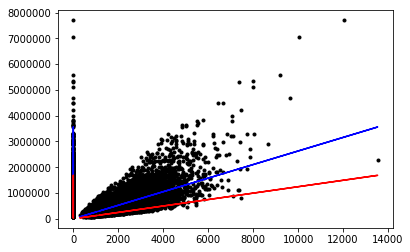

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')
plt.show()

Computing the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Checking which weights perform best?

In [77]:
simple_weights_0_penalty, simple_weights_high_penalt

(array([-1.63113501e-01,  2.63024369e+02]),
 array([  9.76730383, 124.57217565]))

In [78]:
prediction_low_penalty = predict_output(simple_test_feature_matrix, simple_weights_0_penalty)
prediction_high_penalty = predict_output(simple_test_feature_matrix, simple_weights_high_penalty)

In [79]:
RSS_0_penalty = get_residual_sum_of_squares(prediction_low_penalty, test_output)
RSS_high_penalty = get_residual_sum_of_squares(prediction_high_penalty, test_output)

In [80]:
RSS_0_penalty, RSS_high_penalty

(275723634597546.75, 694642100913950.1)

# Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, creating Numpy versions of our training and testing data with these two features. 

In [72]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [73]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_0_penalty`

# Training with 0 L2_penalty

In [74]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 0.0, max_iterations)

Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7433051851026171.0
Iteration = 2
Cost function =  4056752331500973.0
Iteration = 3
Cost function =  2529565114333591.5
Iteration = 4
Cost function =  1838556694275926.0
Iteration = 5
Cost function =  1525675575208603.8
Iteration = 6
Cost function =  1383789498674794.0
Iteration = 7
Cost function =  1319232606276634.2
Iteration = 8
Cost function =  1289648872028921.0
Iteration = 9
Cost function =  1275884724079267.0
Iteration = 10
Cost function =  1269278807577156.5
Iteration = 20
Cost function =  1257812386316614.8
Iteration = 30
Cost function =  1251954571266786.2
Iteration = 40
Cost function =  1246755423155437.5
Iteration = 50
Cost function =  1242139508748821.0
Iteration = 60
Cost function =  1238041401137187.8
Iteration = 70
Cost function =  1234403013463993.2
Iteration = 80
Cost function =  1231172774976820.2
Iteration = 90
Cost function =  1228304900059555.0
Iteration = 100
Cost function =  1225758739

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_high_penalty`

# Training with high L2_penalty

In [75]:
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 1e11, max_iterations)

Starting gradient descent with l2_penalty = 1e+11
Iteration = 1
Cost function =  7433051851026171.0
Iteration = 2
Cost function =  4460489790285892.0
Iteration = 3
Cost function =  3796674468844608.5
Iteration = 4
Cost function =  3648319530437360.5
Iteration = 5
Cost function =  3615091103216102.5
Iteration = 6
Cost function =  3607602742514732.0
Iteration = 7
Cost function =  3605886322161656.0
Iteration = 8
Cost function =  3605474874533295.0
Iteration = 9
Cost function =  3605365167765576.0
Iteration = 10
Cost function =  3605329402184649.0
Iteration = 20
Cost function =  3605294281022695.0
Iteration = 30
Cost function =  3605293537267100.0
Iteration = 40
Cost function =  3605293082749905.0
Iteration = 50
Cost function =  3605292631106358.0
Iteration = 60
Cost function =  3605292179491500.5
Iteration = 70
Cost function =  3605291727877070.0
Iteration = 80
Cost function =  3605291276262784.5
Iteration = 90
Cost function =  3605290824648642.0
Iteration = 100
Cost function =  36052903

In [81]:
multiple_weights_0_penalty, multiple_weights_high_penalty

(array([ -0.35743482, 243.0541689 ,  22.41481594]),
 array([ 6.7429658 , 91.48927361, 78.43658768]))

Computing the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Checking which weights perform best?

In [83]:
multiple_prediction_0_penalty = predict_output(test_feature_matrix, multiple_weights_0_penalty)
multiple_prediction_high_penalty = predict_output(test_feature_matrix, multiple_weights_high_penalty)

In [86]:
multiple_RSS_0_penalty = get_residual_sum_of_squares(multiple_prediction_0_penalty, test_output)
multiple_RSS_high_penalty = get_residual_sum_of_squares(multiple_prediction_high_penalty, test_output)

In [87]:
multiple_RSS_0_penalty, multiple_RSS_high_penalty

(274067618287245.2, 500404800579555.56)

## Calculating the difference between the predicted price by both models & original price of 1st house

In [98]:
multiple_prediction_0_penalty[0] - test_output[0], test_output[0] - multiple_prediction_high_penalty[0]

(77465.47646474396, 39546.46969514142)

From the above we can clearly see that model 2 worked better than first

# Good Luck !!!